# Подготовка моделей на TorchScript для запуска из проекта на С++

In [1]:
import torch
import torchvision

Загрузим для тестов изображения (котика, разумеется!)

In [2]:
import cv2
img = cv2.imread('pics/cat.jpg')
assert img is not None
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Классификация с помощью ResNet34

создадим класс, который, помимо собственно запуска ResNet, подготовит входные данные из обычного RGB изображения   
и сохраним модель в файл **resnet34_infer.pth**


In [3]:
class ResnetInfer(torch.nn.Module):
    '''
    accepts RGB uint8 image as tensor
    returns resnet34 output logits vector[1000] for this image
    '''
    def __init__(self):
        super(ResnetInfer, self).__init__()
        self.mean = [0.485*255, 0.456*255, 0.406*255]
        self.std = [0.229*255, 0.224*255, 0.225*255]
        self.resnet = torchvision.models.resnet34(pretrained = True)
        self.resnet.eval()
        
    def forward(self, img):
        x = img.permute(2,0,1).to(torch.float)
        x = torchvision.transforms.functional.normalize(x, self.mean, self.std).unsqueeze(0) # add batch dimension
        y = self.resnet(x)
        return y.squeeze(0) # remove batch dimension
model = ResnetInfer()    

Посмотрим, как работает:

In [4]:
%%time
with torch.no_grad():
    y = model(torch.tensor(img))
print(y.argmax(), y[y.argmax()])

tensor(282) tensor(12.8130)
Wall time: 1.81 s


Теперь преобразуем это в модель на `TorchScript` и сохраним в файл.

`torchvision.models.resnet34` не скриптуется, поэтому используем трассировку:

In [5]:
sample = torch.randint(low=0, high=255, size=(224, 224, 3), dtype=torch.uint8)
model_scr = torch.jit.trace(model, sample)
model_scr.save('resnet34_infer.pth')

`torchvision.transforms.functional.normalize` создает в своих недрах из списков `mean` и `std` тензоры , причем устройство (cpu/cuda) фиксируется при трассировке. Поэтому придется сохранить два варианта модели: для CPU и для CUDA. Причем во втором случае это будет конкретно cuda:0. Соответственно, при наличии нескольких GPU модель можно будет запустить только на первом из них.

Ниже, в примере модели для сегментации, будет показано, как избавиться от этого недостатка. А пока:

In [6]:
torch.jit.trace(model.cuda(), sample.cuda()).save('resnet34_infer_cuda.pth')

Проверка работы. Ожидаем получить тот же результат, что и выше, а потом и на C++ получить то же самое:

In [7]:
model_scr = torch.jit.load('resnet34_infer.pth')

In [8]:
%%time
with torch.no_grad():
    y = model_scr(torch.tensor(img))
assert y.argmax() == 282 # "cat"
assert int(y[y.argmax()]) == 12 #~12.8133
print(y.argmax(), y[y.argmax()])

tensor(282) tensor(12.8130)
Wall time: 1.86 s


## Сегментация с помощью DeepLabV3

В репозитории https://github.com/VainF/DeepLabV3Plus-Pytorch есть предобученные веса для DeepLabV3Plus.  

Устанавливает модель из репозитория:

In [9]:
!git clone "https://github.com/VainF/DeepLabV3Plus-Pytorch.git"

Cloning into 'DeepLabV3Plus-Pytorch'...


Скачиваем checkpoint для DeepLabV3Plus-MobileNetV2, см. [ссылку в VainF/DeepLabV3Plus-Pytorch](https://github.com/VainF/DeepLabV3Plus-Pytorch#results-on-pascal-voc2012-aug-in-progress)

In [10]:
url = 'https://www.dropbox.com/s/0idrhwz6opaj7q4/best_deeplabv3plus_mobilenet_voc_os16.pth?dl=1'
checkpoint_filename = './DeepLabV3Plus-Pytorch/best_deeplabv3plus_mobilenet_voc_os16.pth'

In [11]:
import urllib.request
print('Beginning file download pretrained DeepLabV3Plus ...')
urllib.request.urlretrieve(url, checkpoint_filename)
print('done')

Beginning file download pretrained DeepLabV3Plus ...
done


Так же, как и для ResNet, создадим класс, который помимо собственно запуска модели подготовит входные данные из обычного RGB изображения
и сохраним модель в файл **deep_lab_v3_infer.pth**

Также **избавимся от необходимости сохранять отдельные варианты модели для CPU и для GPU**.
Для этого надо отказаться от использования функции `torchvision.transforms.functional.normalize`, которая сама создает тензор из списков `mean` и `std`, и написать соответствующее преобразование вручную. А параметы нормализации надо сделать экземплярами `torch.nn.Parameter`. В этом случае при загрузке модели они будут отправлены на то устройство, которое указано. Разумеется, там же должен быть размещен и тензор обрабатываемого изображения.

Кроме того, сделаем так, чтобы модель могла обрабатывать сразу список картинок в виде батча, а батч можно было передать или как список отдельных картинок, или как готовый 4D тензор. Возвращать модель будет кортеж результатов: отклики по всем классам, классы в каждой точке, а также демо-картинку: исходное изображение с наложенным на него результатом сегментации. В проекте на С++ продемонстрировано, как с этим работать.

In [12]:
import sys
sys.path.append('./DeepLabV3Plus-Pytorch')
import network as DeepLabV3

In [13]:
from typing import List
from torch import Tensor

class DeepLabV3Infer(torch.nn.Module):
    '''
    Aaccepts list of RGB uint8 images converted to tensors (HWC)
    or a list containing single 4D tensor (BHWC) batch of images.
    Returns a tuple of (logits, labels, demo_imgs), each tensor has a batch dimension.
    '''
    def __init__(self):
        super(DeepLabV3Infer, self).__init__()
        self.mean = torch.nn.Parameter(torch.tensor([0.485*255, 0.456*255, 0.406*255]))
        self.std = torch.nn.Parameter(torch.tensor([0.229*255, 0.224*255, 0.225*255]))
        self.model = DeepLabV3.deeplabv3plus_mobilenet(pretrained = False, num_classes=21, output_stride=8)
        checkpoint = torch.load(checkpoint_filename)
        self.model.load_state_dict(checkpoint["model_state"])
        self.model.eval()
        sample = torch.rand(size=(1,3,224,224))
        self.model = torch.jit.trace(self.model, sample)

    def forward(self, imgs: List[Tensor]):
        if len(imgs) == 1 and len(imgs[0].shape) == 4:
            imgs_tensor = imgs[0]
        else:
            imgs_tensor = torch.stack(imgs, dim=0)
        x = imgs_tensor.permute(0,3,1,2).to(torch.float)
        x = x.sub(self.mean[None, :, None, None]).div(self.std[None, :, None, None])
        logits = self.model(x)
        labels = logits.argmax(1).to(torch.uint8)
        demo_imgs = imgs_tensor/2
        demo_imgs[:,:,:,1] += labels*5 # halftone original image and highlight segmented area with green
        return logits, labels, demo_imgs
seg_model = DeepLabV3Infer()    

Проверим работу:

In [14]:
%%time
with torch.no_grad():
    logits, labels, demo_imgs = seg_model([torch.tensor(img),])

Wall time: 3.14 s


In [15]:
import numpy as np
from matplotlib import gridspec
from matplotlib import pyplot as plt

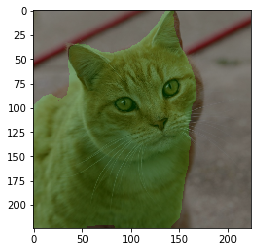

In [16]:
plt.imshow(demo_imgs[0])
plt.show()

и сохраним модель:

In [17]:
seg_model = torch.jit.script(seg_model)
seg_model.save('deep_lab_v3_infer.pth')

## Проверим, как это будет работать на GPU

Весь код ниже автономен, не требует выполнения того, что релалось выше для подготовки моделей.
Поэтому делаем повторно все необходимые импорты и загружаем тестовую картинку. От PyTorch импортировать надо только `torch.jit`

In [18]:
import torch.jit
import cv2

img = cv2.imread('pics/cat.jpg')
assert img is not None
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Классификация с ResNet34:

на CPU:

In [19]:
model = torch.jit.load('resnet34_infer.pth')

In [20]:
%%time
with torch.no_grad():
    y = model(torch.tensor(img))
print(y.argmax(), y[y.argmax()])

tensor(282) tensor(12.8130)
Wall time: 1.9 s


и на GPU:

In [21]:
model = torch.jit.load('resnet34_infer_cuda.pth', map_location = 'cuda')

In [22]:
%%time
with torch.no_grad():
    y = model(torch.tensor(img).cuda())
    y = y.cpu()
print(y.argmax(), y[y.argmax()])

tensor(282) tensor(12.8130)
Wall time: 68 ms


### Сегментация

In [23]:
device = 'cuda'

Запускаем сразу на GPU. Если нужно использовать CPU, изменяем переменную выше на `device = 'cpu'`. Других отличий нет.

In [24]:
model = torch.jit.load('deep_lab_v3_infer.pth', map_location = device)

Обработаем для примера сразу 10 одинаковых картинок:

In [25]:
%%time
with torch.no_grad():
    logits, labels, demo_imgs = model([torch.tensor(img, device = device)]*10)
demo_imgs = demo_imgs.cpu()

Wall time: 358 ms


Рисуем, что получилось:

In [26]:
from matplotlib import gridspec
from matplotlib import pyplot as plt

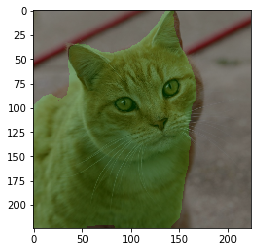

In [27]:
plt.imshow(demo_imgs[0])
plt.show()

Ура, товарищи!